In [3]:
!pip install matplotlib
!pip install yfinance
!pip install scipy
!pip install seaborn
!pip install pandas

In [4]:
import datetime as dt
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

In [5]:
pd.__version__


'2.2.3'

In [6]:
start_date = dt.date(2010,1,1)
end_date = dt.date(2023, 12,31)

In [7]:
sp = yf.download("SPY", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [8]:
spy_ret = np.log(sp['Adj Close']).diff()

<Axes: xlabel='Date'>

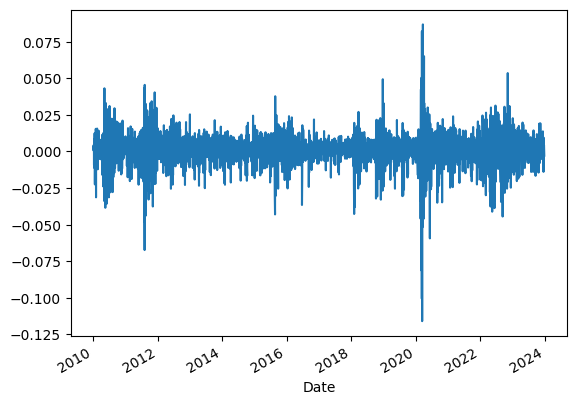

In [9]:
# plot return series to show volatility clustering
spy_ret.plot()

In [10]:
# cdf graphs to show fat tail
ref_mean = spy_ret.mean()
ref_std = spy_ret.std()

norm_reference = np.random.normal(loc=ref_mean, scale=ref_std, size=spy_ret.shape[0])


In [11]:
plot_df = pd.DataFrame({'Normal Reference': norm_reference, 'SPY Historical Returns': spy_ret}).dropna()

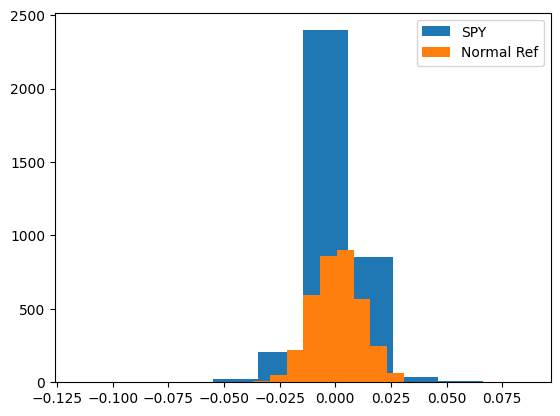

In [12]:
plt.hist(plot_df['SPY Historical Returns'], label='SPY')
plt.hist(plot_df['Normal Reference'], label='Normal Ref')
plt.legend()
plt.show()